In [20]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns

In [21]:
def load_data_Urbun(sheet):
    df_urban = {}
    years = ['1400', '1401']
    for year in years:
        file_name = f'U{year}.xlsx'
        sheet_name = f'U{year}{sheet}'
        df = pd.read_excel(file_name, sheet_name = sheet_name)
        df_urban[f'U{year}'] = df
    return df_urban

In [22]:
Urbun_data_income_paid_jobs = load_data_Urbun('P4S01')

Urbun_data_income_freelance_jobs = load_data_Urbun('P4S02')

Urbun_data_income_Miscellaneous = load_data_Urbun('P4S03')

Urbun_data_income_subsidy = load_data_Urbun('P4S04')

#### Group By

In [23]:
Urbun_data_income_freelance_jobs['U1401']['income_s_y'] = Urbun_data_income_freelance_jobs['U1401']['income_s_y'].apply(lambda x : x.strip())

Urbun_data_income_freelance_jobs['U1401']['income_s_y'] = Urbun_data_income_freelance_jobs['U1401']['income_s_y'].apply(lambda x : x if x != '' else '0')

Urbun_data_income_freelance_jobs['U1401']['income_s_y'] = Urbun_data_income_freelance_jobs['U1401']['income_s_y'].astype('float')

In [24]:
Urbun_data_income_Miscellaneous['U1400'].loc[318 , 'income_pension'] = '0'
Urbun_data_income_Miscellaneous['U1400'] = Urbun_data_income_Miscellaneous['U1400'].astype('float')

In [25]:
# Paid Jobs
paid_jobs = {}
for key, value in Urbun_data_income_paid_jobs.items():
    paid_jobs[key] = value.groupby('Address')[['netincome_w_y']].agg('sum').reset_index()
    
# Freelance Jobs
Freelance_Jobs = {}
for key, value in Urbun_data_income_freelance_jobs.items() :
    Freelance_Jobs[key] = value.groupby('Address')[['income_s_y']].agg('sum').reset_index()
    
# Miscellaneous
Miscellaneous = {}
selected_columns = ['income_pension', 'income_rent', 'income_interest', 'income_aid', 'income_resale', 'income_transfer']
for key in Urbun_data_income_Miscellaneous.keys():
    Miscellaneous[key] = Urbun_data_income_Miscellaneous[key].groupby('Address')[selected_columns].agg('sum').reset_index()
    
# Subsidy 
Subsidy = {}
for key, value in Urbun_data_income_subsidy.items():
    Subsidy[key] = value.groupby('Address')[['subsidy']].agg('sum').reset_index()

#### Process Income

In [26]:
def process_income_data_Urbun(years):
    ans = {}
    for year in years :
        
        df = paid_jobs[f'U{year}'].merge(Freelance_Jobs[f'U{year}'], how = 'outer')

        df = df.merge(Miscellaneous[f'U{year}'], how = 'outer')

        df = df.merge(Subsidy[f'U{year}'], how='outer')
        
        ans[f'number{year}'] = df['Address'].nunique()

        df = df.drop(columns='Address')

        df.dropna(how='all', inplace=True)

        df.fillna(0, inplace=True)

        df = df.astype('float')

        df = df.sum(axis=1)
        
        ans[f'{year}'] = df
        
    return ans

In [27]:
years = ['1400', '1401']
Urban_data_income = process_income_data_Urbun(years)

#### برای تحلیل جواب تست اندرسون

In [28]:
def Anderson(result) :
    print(f"Statistic: {result.statistic}")
    print(f"Critical Values: {result.critical_values}")
    print(f"Significance Levels: {result.significance_level}")
    
    for i in range(len(result.critical_values)):
        if result.statistic > result.critical_values[i]:
            print(f"At the {result.significance_level[i]}% significance level, data is NOT normal.")
        else:
            print(f"At the {result.significance_level[i]}% significance level, data is normal.")

### فرضیات

- **H0**: میزان درآمد افراد شهری در سال ۱۴۰۱ نسبت به سال ۱۴۰۰ افزایش یافته است
- **H1**:میزان درآمد افراد شهری در سال ۱۴۰۱ نسبت به سال ۱۴۰۰ کاهش یافته است
- **ALPHA** : 0.5

In [29]:
anderson_1400 = stats.anderson(Urban_data_income['1400'])
anderson_1401 = stats.anderson(Urban_data_income['1401'])
Anderson(anderson_1400)
print()
Anderson(anderson_1401)

Statistic: 963.683927443577
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 1163.3046928004987
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


In [30]:
stats.mannwhitneyu(Urban_data_income['1400'], Urban_data_income['1401'], alternative = 'less')

MannwhitneyuResult(statistic=126885872.5, pvalue=0.0)

- از آلفا خیلی کمتره مقدار پی پس فرض ضفر رد میشه

#### تلاش برای نرمال سازی

In [31]:
yeojohnson_1400 , _ = stats.yeojohnson(Urban_data_income['1400'])
yeojohnson_1401 , _ = stats.yeojohnson(Urban_data_income['1401'])
anderson_yeojohnson_1400 = stats.anderson(yeojohnson_1400)
anderson_yeojohnson_1401 = stats.anderson(yeojohnson_1401)
Anderson(anderson_yeojohnson_1400)
print()
Anderson(anderson_yeojohnson_1401)

Statistic: 757.1266692267563
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 920.9819314592678
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


In [32]:
log_1400 = np.log(Urban_data_income['1400'])
log_1401 = np.log(Urban_data_income['1401'])

log_1400.dropna(inplace = True)
log_1400 = log_1400[~np.isinf(log_1400)]

log_1401.dropna(inplace = True)
log_1401 = log_1401[~np.isinf(log_1401)]

anderson_log_1400 = stats.anderson(log_1400)
anderson_log_1401 = stats.anderson(log_1401)

Anderson(anderson_log_1400)
print()
Anderson(anderson_log_1401)

Statistic: 274.27523113293137
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 353.2980963285918
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


d:\miniconda3\envs\bootcamp\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\miniconda3\envs\bootcamp\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
sqrt_1400 = np.sqrt(Urban_data_income['1400'])
sqrt_1401 = np.sqrt(Urban_data_income['1401'])

sqrt_1400.dropna(inplace = True)
sqrt_1400 = sqrt_1400[~np.isinf(sqrt_1400)]

sqrt_1401.dropna(inplace = True)
sqrt_1401 = sqrt_1401[~np.isinf(sqrt_1401)]

anderson_sqrt_1400 = stats.anderson(sqrt_1400)
anderson_sqrt_1401 = stats.anderson(sqrt_1401)
Anderson(anderson_sqrt_1400)
print()
Anderson(anderson_sqrt_1401)

Statistic: 115.19730236554824
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.

Statistic: 147.5928552974292
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]
At the 15.0% significance level, data is NOT normal.
At the 10.0% significance level, data is NOT normal.
At the 5.0% significance level, data is NOT normal.
At the 2.5% significance level, data is NOT normal.
At the 1.0% significance level, data is NOT normal.


d:\miniconda3\envs\bootcamp\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


- داده ها نرمال نشدن پس همچنان فرض صفر رد میمونه

#### آیا سطح زندگی مردم تغییر کرده

- میام به هرکدوم از ویژگی ها بین 1 که میشه فقیر 2 میشه نرمال و 3 میشه پولدار نمره میدم بعد جمع میکنم اون جمع ها هم تقسیم میکنم به سطح زندگی افراد

In [34]:
living_Data = load_data_Urbun('P2')

In [35]:
living_Data['U1400'][['room', 'space']].corr()

,room,space
room,1.000000,0.814061
space,0.814061,1.000000


In [36]:
living_Data['U1401'][['room', 'space']].corr()

,room,space
room,1.000000,0.599627
space,0.599627,1.000000


- کور یکی بالا نیست پس نمیتونم اتاق رو حذف کنم فقط با متراژ برم

In [37]:
def room(x) :
    if x < 3 : 
        return 0
    elif x < 5 :
        return 1
    else :
        return 2

In [38]:
living_Data['U1400']['room_score'] = living_Data['U1400']['room'].apply(lambda x : room(x))
living_Data['U1400'].drop(columns = 'room' ,inplace = True)
living_Data['U1401']['room_score'] = living_Data['U1401']['room'].apply(lambda x : room(x))
living_Data['U1401'].drop(columns = 'room' ,inplace = True)

In [39]:
def tenure(x) :
    if x == 'Service' or x == 'Free' or x == 'Free':
        return 0
    elif x == 'Mortgage' or x == 'Rent' :
        return 1
    else :
        return 2

In [40]:
living_Data['U1400']['tenure_score'] = living_Data['U1400']['tenure'].apply(lambda x : tenure(x))
living_Data['U1400'].drop(columns = 'tenure', inplace = True)

living_Data['U1401']['tenure_score'] = living_Data['U1401']['tenure'].apply(lambda x : tenure(x))
living_Data['U1401'].drop(columns = 'tenure', inplace = True)

In [41]:
def space(x) :
    if x < 70 :
        return 0
    elif x <= 130 :
        return 1
    else :
        return 2

In [42]:
living_Data['U1400']['space_score'] = living_Data['U1400']['space'].apply(lambda x : space(x))
living_Data['U1400'].drop(columns = 'space', inplace = True)

living_Data['U1401']['space_score'] = living_Data['U1401']['space'].apply(lambda x : space(x))
living_Data['U1401'].drop(columns = 'space', inplace = True)

In [43]:
living_Data['U1400'].drop(columns = 'material', inplace = True)
living_Data['U1401'].drop(columns = 'material', inplace = True)

In [44]:
living_Data['U1400'].drop(columns = 'construction', inplace = True)
living_Data['U1401'].drop(columns = 'construction', inplace = True)

In [45]:
def TF(x) :
    if x :
        return 1
    else :
        return 0

In [46]:
List = ['vehicle', 'motorcycle', 'bicycle', 'radio', 'radiotape',
       'TVbw', 'TV', 'VHS_VCD_DVD', 'computer', 'cellphone', 'freezer',
       'refridgerator', 'fridge', 'stove', 'vacuum', 'washingmachine',
       'sewingmachine', 'fan', 'evapcoolingportable', 'splitportable',
       'dishwasher', 'microwave', 'none', 'pipewater', 'electricity',
       'pipegas', 'telephone', 'internet', 'bathroom', 'kitchen',
       'evapcooling', 'centralcooling', 'centralheating', 'package', 'split',
       'wastewater']

In [47]:
for item in List :
    living_Data['U1400'][item] = living_Data['U1400'][item].apply(lambda x : TF(x))
    living_Data['U1401'][item] = living_Data['U1401'][item].apply(lambda x : TF(x))

In [48]:
def cookingfuel(x) :
    if x == 'LiquidGas' or x == 'Gasoline' or x == 'Oil' :
        return 0
    else :
        return 1

In [49]:
living_Data['U1400']['cookingfuel'] = living_Data['U1400']['cookingfuel'].apply(lambda x : cookingfuel(x))
living_Data['U1401']['cookingfuel'] = living_Data['U1401']['cookingfuel'].apply(lambda x : cookingfuel(x))

In [50]:
def heatingfuel(x):
    if x == 'NaturalGas' or x == 'Electricity':
        return 1
    else :
        return 0

In [51]:
living_Data['U1400']['heatingfuel'] = living_Data['U1400']['heatingfuel'].apply(lambda x : heatingfuel(x))
living_Data['U1401']['heatingfuel'] = living_Data['U1401']['heatingfuel'].apply(lambda x : heatingfuel(x))

In [52]:
living_Data['U1400']['waterheatingfuel'] = living_Data['U1400']['waterheatingfuel'].apply(lambda x : heatingfuel(x))
living_Data['U1401']['waterheatingfuel'] = living_Data['U1401']['waterheatingfuel'].apply(lambda x : heatingfuel(x))

In [53]:
living_Data['U1400'].drop(columns = 'Address', inplace = True)
living_Data['U1401'].drop(columns = 'Address', inplace = True)

In [65]:
score_1400 = living_Data['U1400'].sum(axis = 1)
score_1401 = living_Data['U1401'].sum(axis = 1)

In [64]:
def change_score(x) :
    if x <= 12 :
        return 'Poor'
    elif x <= 22 :
        return 'Normal'
    else :
        return 'Rich'

In [66]:
score_1400 = score_1400.apply(lambda x : change_score(x))
score_1401 = score_1401.apply(lambda x : change_score(x))

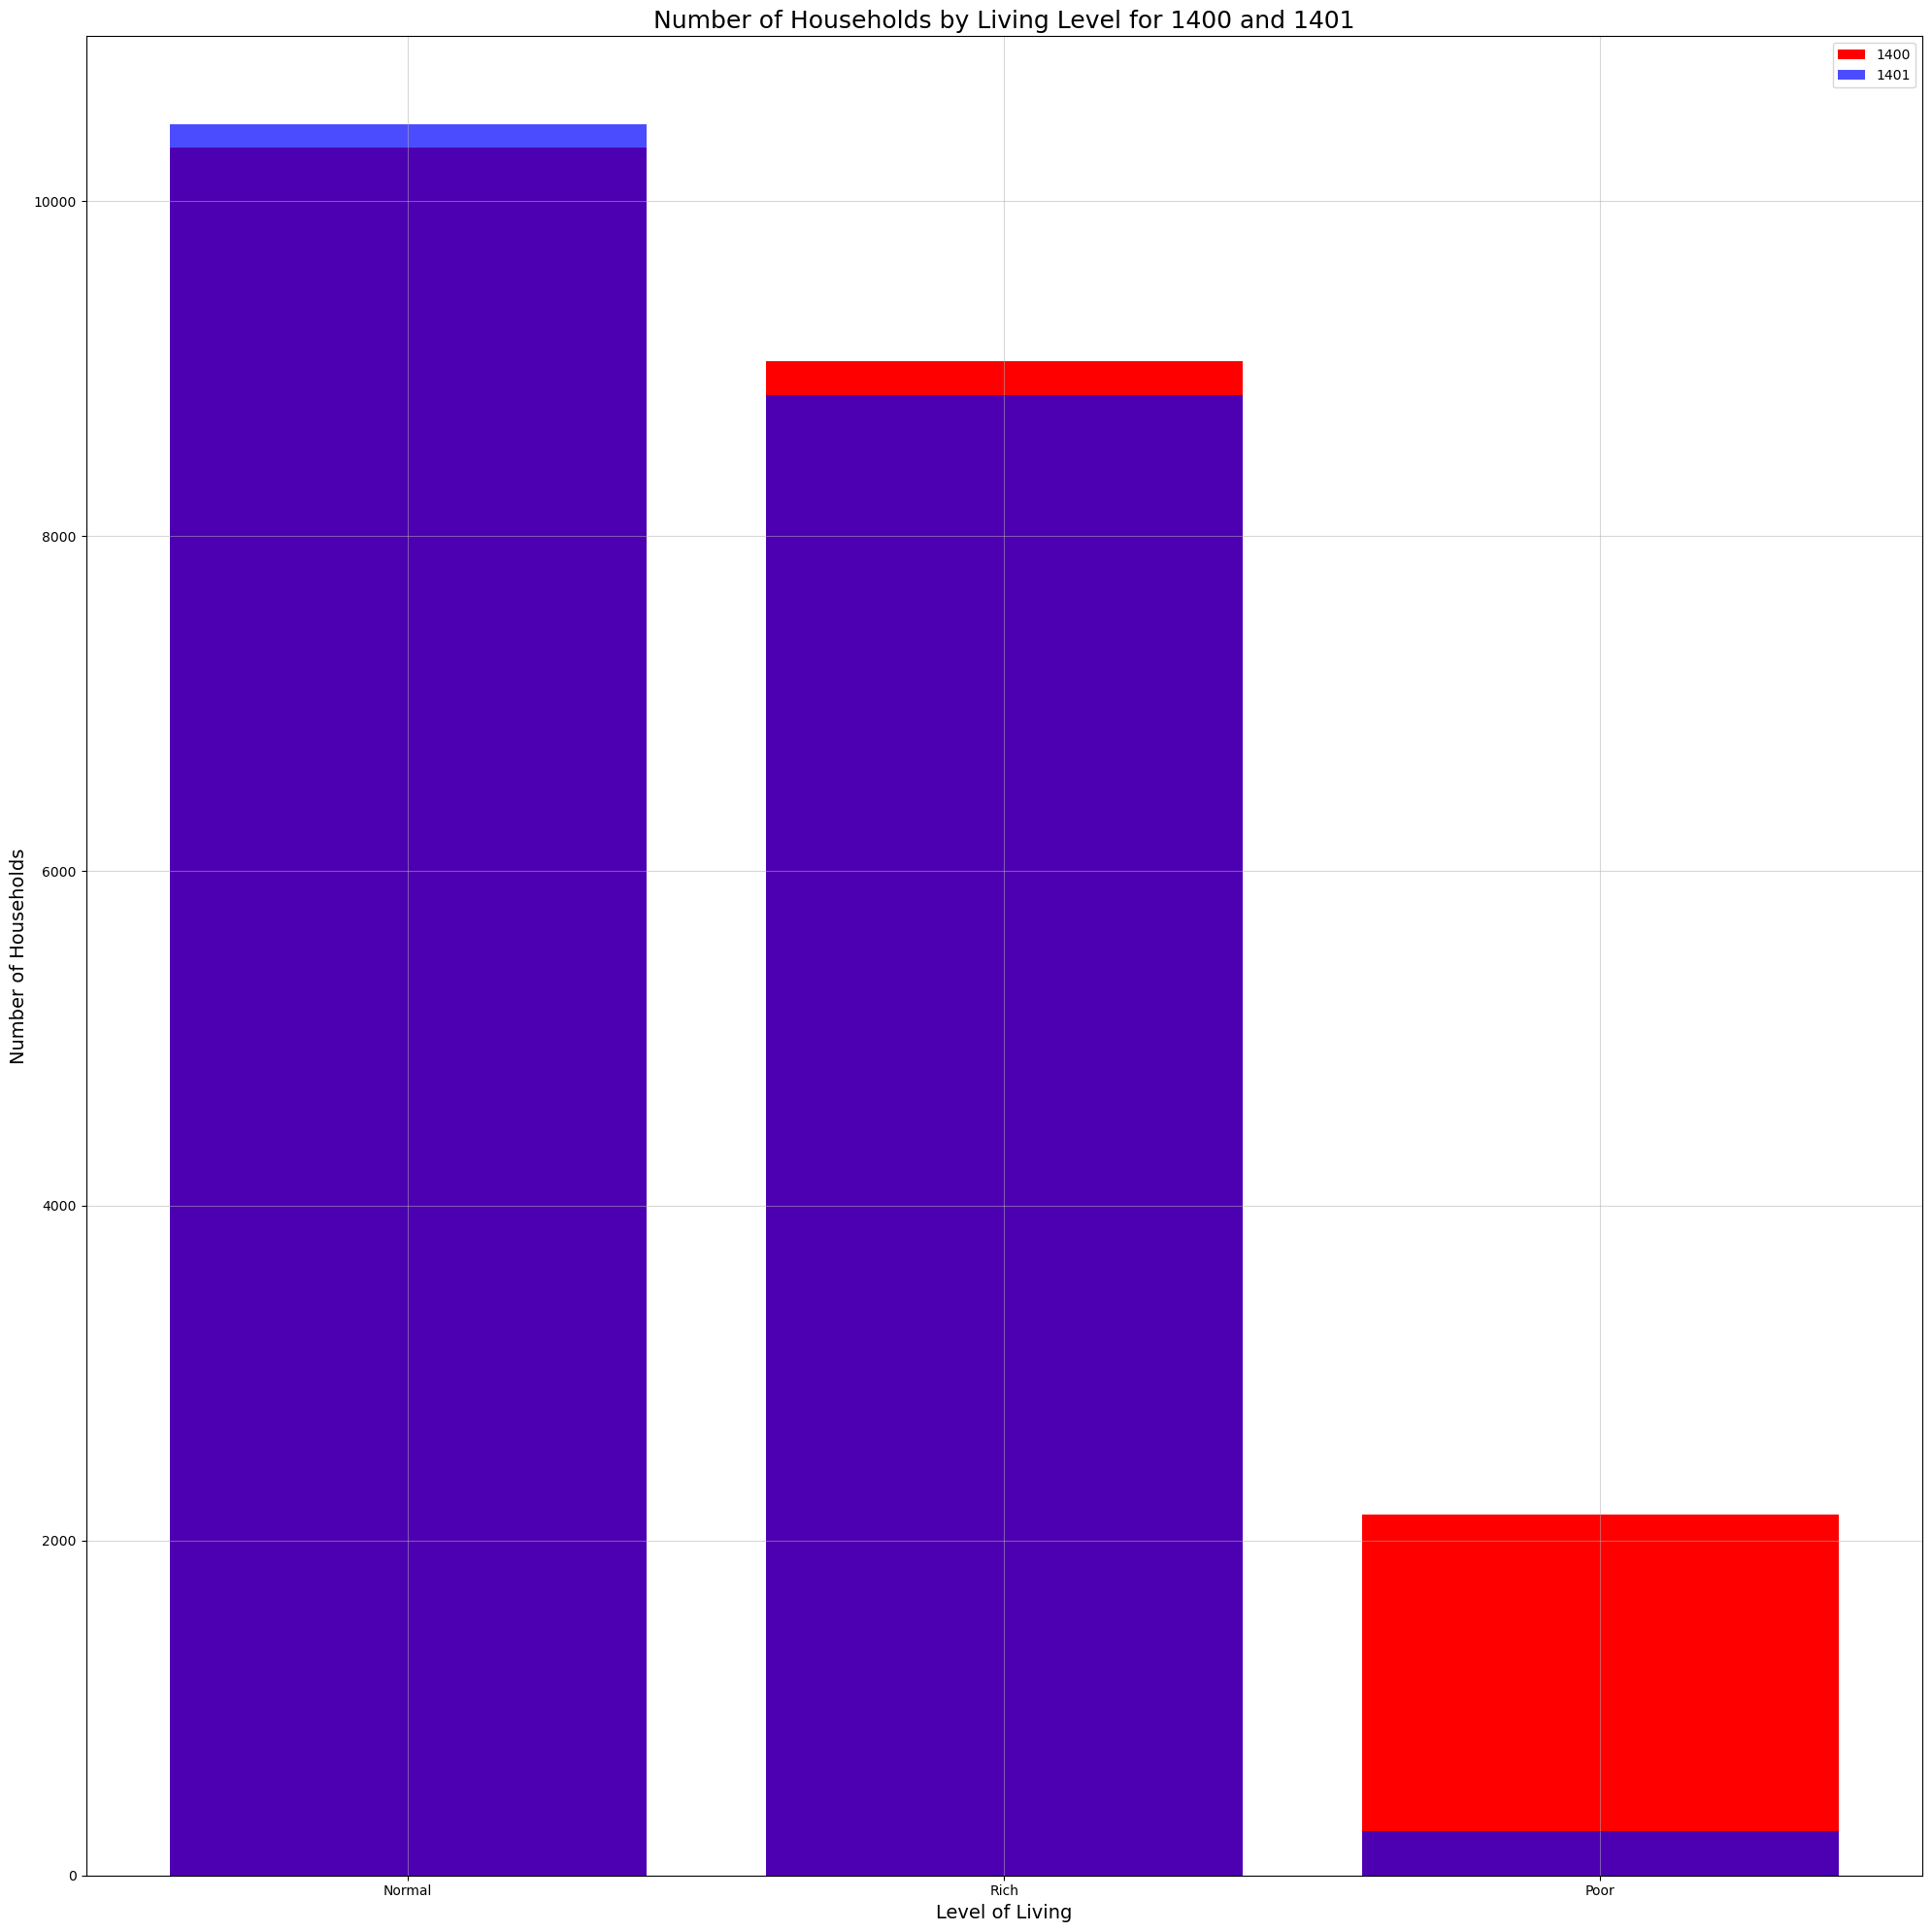

In [67]:
plt.figure(figsize=(20 , 20))
plt.bar(['Normal', 'Rich', 'Poor'], score_1400.value_counts(), color='r', label = 1400)
plt.grid(True, alpha = 0.5)
plt.bar(['Normal', 'Rich', 'Poor'], score_1401.value_counts(),  color='b', alpha = 0.7, label = 1401)
plt.grid(True, alpha = 0.5)
plt.xlabel('Level of Living', fontsize=14)
plt.ylabel('Number of Households', fontsize=14)
plt.title('Number of Households by Living Level for 1400 and 1401', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()

طبق نمودار میشه فهمید با اینکه درآمد در طول 2 سال تغییر چشم گیری نداشته توقع داشتیم که حداقل افراد در همون سطح بمونن ولی افراد فقیر که خیلی کم شدن ولی افراد پولدار یکم کمتر شدن
پس میشه گفت که رفاه زندگی شون بیشتر شده

ولی نمیشه بگیم با توجه به نمودار پس یه ازمون فرض هم میریم

In [84]:
scores = pd.DataFrame({1400 : score_1400.value_counts(), 1401 : score_1401.value_counts()})
scores

,1400,1401
Normal,10318,10462
Rich,9043,8840
Poor,2155,265


In [69]:
stats.chi2_contingency(scores)

Chi2ContingencyResult(statistic=1390.0434429993502, pvalue=1.4318632734228268e-302, dof=2, expected_freq=array([[10882.90728525,  9897.09271475],
       [ 9365.68965265,  8517.31034735],
       [ 1267.40306209,  1152.59693791]]))

- **H0**: توزیع مقادیر در دو گروه مشابه است
- **H1**: توزیع مقادیر در دو گروه مشابه نیست
- **ALPHA** : 0.05

### تحلیل آزمون Chi-Square

**نتایج آزمون Chi-Square**:

- **آماره آزمون (Chi-Square Statistic)**: 1390.04
- **مقدار p (P-value)**: 1.43e-302
- **درجه آزادی (Degrees of Freedom)**: 2

#### فراوانی‌های مورد انتظار (Expected Frequencies):
| گروه‌ها         | دسته 1     | دسته 2     |
|-----------------|------------|------------|
| گروه 1          | 10882.91   | 9897.09    |
| گروه 2          | 9365.69    | 8517.31    |
| گروه 3          | 1267.40    | 1152.60    |

### تحلیل:
- **آماره آزمون Chi-Square** برابر با 1390.04 است که نشان‌دهنده تفاوت قابل‌توجه بین فراوانی‌های مشاهده شده و فراوانی‌های مورد انتظار است.
- **مقدار p (P-value)** بسیار کوچک (حدود 1.43e-302) است که نشان می‌دهد احتمال بسیار کمی وجود دارد که این تفاوت‌ها تصادفی باشند. بنابراین، فرض صفر (عدم تفاوت بین گروه‌ها) با اطمینان بسیار بالا رد می‌شود.
- **درجه آزادی** 2 نشان می‌دهد که این آزمون بر روی داده‌هایی با سه دسته مستقل انجام شده است.

### نتیجه‌گیری:
با توجه به آماره آزمون و مقدار p بسیار کوچک، تفاوت‌های مشاهده شده بین دسته‌های مختلف از نظر آماری معنادار هستند.


با اینکه ازمون میگه توزیع مقادیر در دو گروه مشابه نیست و تفاوت معناداری بین آن‌ها وجود دارد ولی باید به تعداد افراد هر سال هم توجه کرد

In [71]:
scores.sum(axis=0)

1400    21516
1401    19567
dtype: int64

- سال 1400 : 21516
- سال 1401 : 19567

In [77]:
21516 - 19567

1949

حدود 2000 نفر تفاوت دارن که اگه این مقدار رو فرض بگیریم برای افراد فقیری بودن که کم شدن و یه بار دیگه ازمون رو انجام بدیم

In [85]:
scores.loc['Poor', 1401] += 1949
scores

,1400,1401
Normal,10318,10462
Rich,9043,8840
Poor,2155,2214


In [87]:
scores[1400].index

Index(['Normal', 'Rich', 'Poor'], dtype='object')

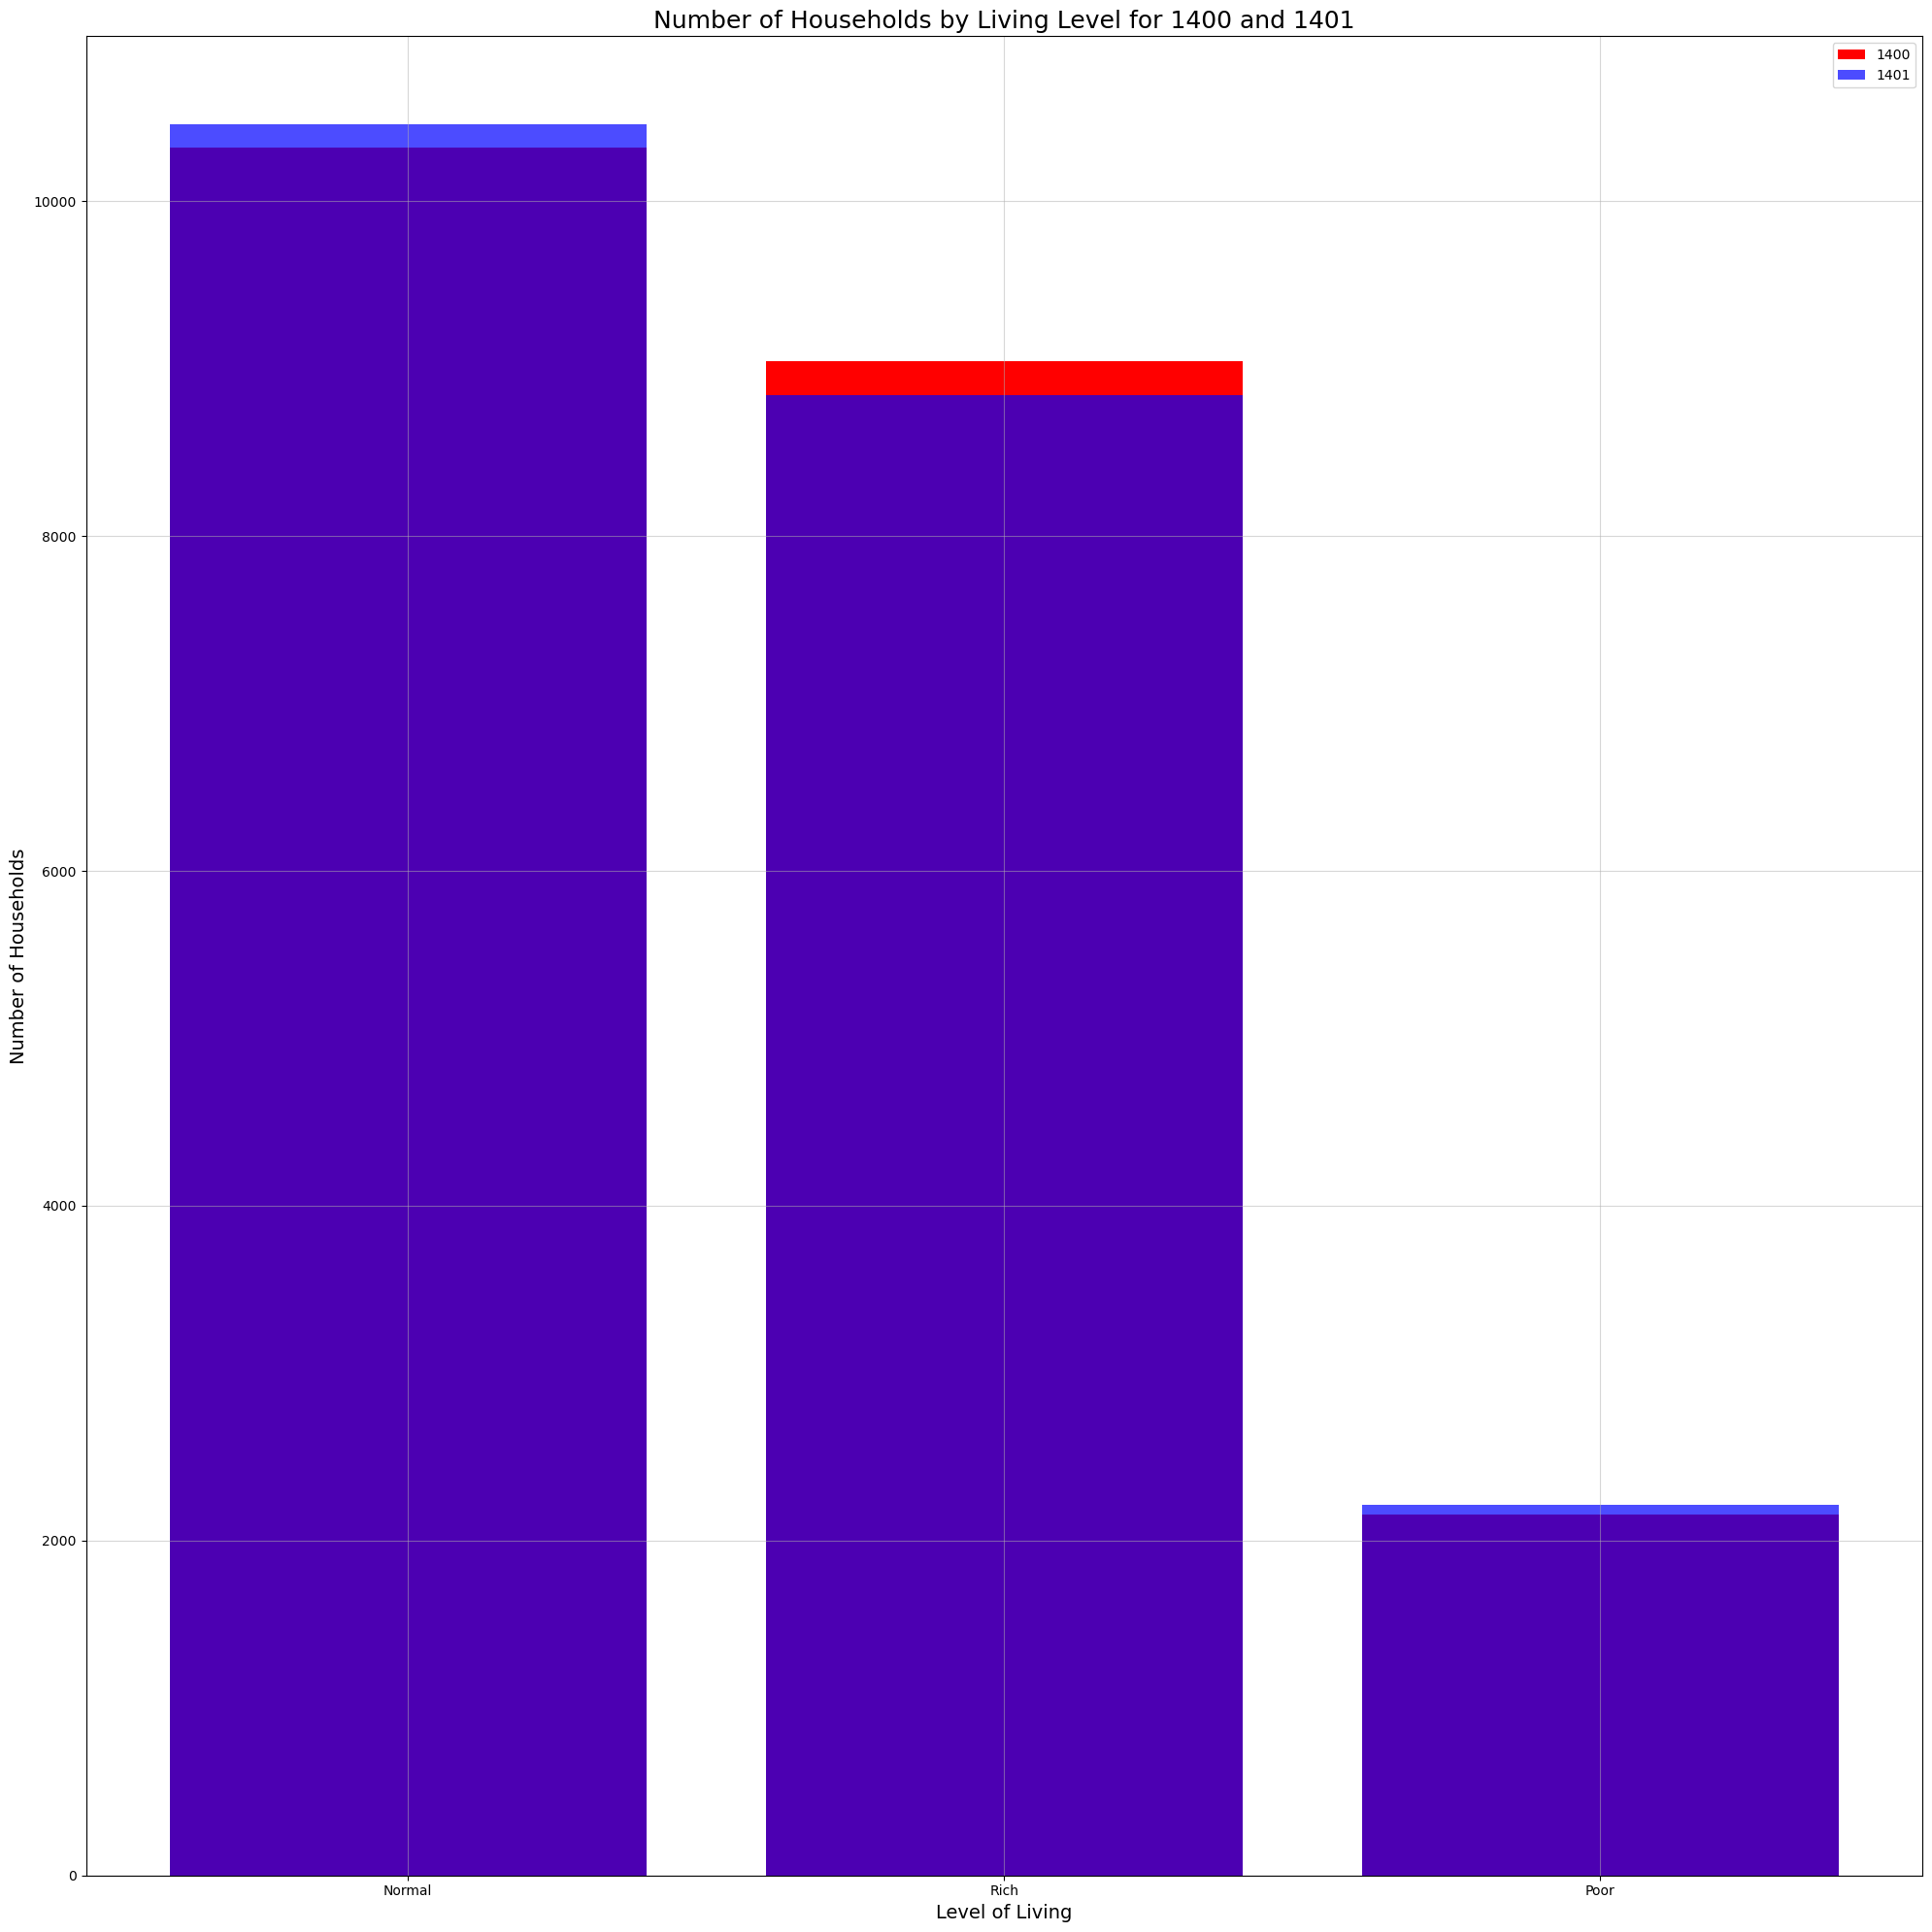

In [88]:
plt.figure(figsize=(20 , 20))
plt.bar(scores[1400].index, scores[1400], color='r', label = 1400)
plt.grid(True, alpha = 0.5)
plt.bar(scores[1401].index, scores[1401],  color='b', alpha = 0.7, label = 1401)
plt.grid(True, alpha = 0.5)
plt.xlabel('Level of Living', fontsize=14)
plt.ylabel('Number of Households', fontsize=14)
plt.title('Number of Households by Living Level for 1400 and 1401', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()

In [89]:
stats.chi2_contingency(scores)

Chi2ContingencyResult(statistic=4.098999683923362, pvalue=0.12879930748936783, dof=2, expected_freq=array([[10390. , 10390. ],
       [ 8941.5,  8941.5],
       [ 2184.5,  2184.5]]))

### تحلیل آزمون Chi-Square

**نتایج آزمون Chi-Square**:

- **آماره آزمون (Chi-Square Statistic)**: 4.10
- **مقدار p (P-value)**: 0.1288
- **درجه آزادی (Degrees of Freedom)**: 2

#### فراوانی‌های مورد انتظار (Expected Frequencies):
| گروه‌ها         | دسته 1     | دسته 2     |
|-----------------|------------|------------|
| گروه 1          | 10390.00   | 10390.00   |
| گروه 2          | 8941.50    | 8941.50    |
| گروه 3          | 2184.50    | 2184.50    |

### تحلیل:
- **آماره آزمون Chi-Square** برابر با 4.10 است که نشان‌دهنده وجود تفاوت‌های کوچکی بین فراوانی‌های مشاهده شده و فراوانی‌های مورد انتظار است.
- **مقدار p (P-value)** برابر با 0.1288 است که **بزرگ‌تر** از سطح معناداری 0.05 است. این به این معناست که شواهد کافی برای رد فرض صفر (**H0**) وجود ندارد.

### نتیجه‌گیری:
- **فرض صفر (H0)**: "توزیع مقادیر در دو گروه مشابه است" **رد نمی‌شود**.
- بنابراین، نتیجه‌گیری می‌شود که **توزیع مقادیر در دو گروه مشابه است** و تفاوت معناداری بین گروه‌ها وجود ندارد.


اینجا ولی تنیجه معکوس میگیریم پس میشه گفت که داده های 1401 ممکنه ناقص باشه پس اگه بخوایم بر اساس داده های موجود بگیم باید بگیم که فرض صفر رد میشه